In [1]:
from neural_network import NeuralNetwork 
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline  
from itertools import product
from mpl_toolkits import mplot3d

import pandas as pd

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Setup

Before beginning I developed my network into an API that could easily be used for the experiments. SSE_epochs records the epoch-wise error. network.train allows a number of epochs to train for and an error delta cut off. In all experiments I used the error delta cut off which stops training once the difference in SSE falls below this level. I then put in a high epoch number that would never be reached prior to the delta cutoff.


- An error delta cutoff of .001 was used in all experiments. 
- Learning rate and momentum are initialized when the NeuralNetowork class is made
- The network can be initialized based on files or randomly



### 1) First train a basic network with alpha .7 

First I created a basic network with learning rate of .7 and momentum of .3. I trained the network until the sum of squared errors dropped by less than .001 between epochs. The network converges nicely, with the error dropping off rapidly at the beginning then more slowly later on. I find the shape of this curve interesting. Error decreases very quickly initially, then it is more work to achieve the remaining loss improvement.


In [ ]:
#Load the dataset        
dataset = genfromtxt('training_data.csv', delimiter=',')
training = dataset[:,0:3]
testing = dataset[:,3:5]

#Create a 3:11:2 network with alpha and bias    
network = NeuralNetwork(3, 11, 2, .7, .3)
network.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')

#Train until the SSE delta is below threshold
network.train(300, training, testing, .001)

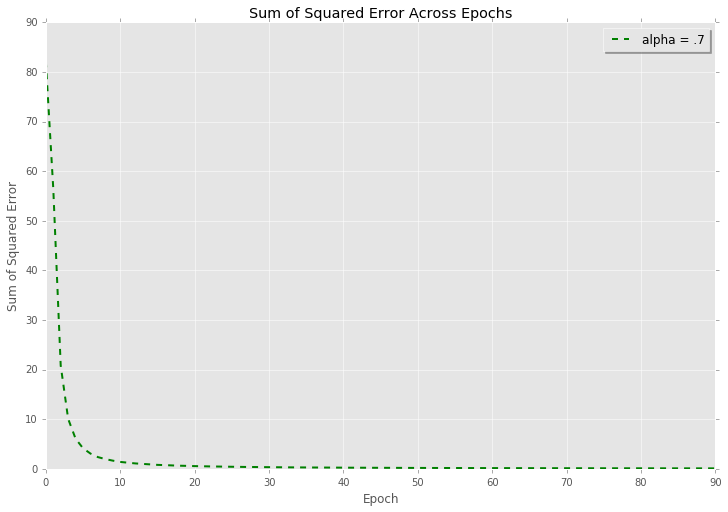

In [63]:
# Plot initial training
t = range(len(network.SSE_epochs))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, network.SSE_epochs, 'g--', label='alpha = .7', linewidth=2)
ax.set_ylabel('Sum of Squared Error')
ax.set_xlabel('Epoch')
ax.set_title("Sum of Squared Error Across Epochs")
legend = ax.legend(loc='upper right', shadow=True)

### I then constructed a topo plot of the decision boundary


This requires creating an evaluation dataset that has every pair of coordinates in the range of -2.1 - 2.1 and storing them as the first feature dimensions, which ends up with an array of 177241 samples to feed in for evaluation. I then added a third feature made from uniform Gaussian noise, with values between -.001 and .001. The returned predictions were plotted in a 3D scatter plot in order to get an idea of the decision boundary between the two classes. Due to the density, the boundary appears continuous. 

Plotting the first and second output, as well as the difference between the two, shows that the decision boundary forms a cross, similarly to the data distribution.

In [72]:
# Construct gird of data as specified [-2.1,2.1] with random numbers from -.001, .001 following a uniform distribution
decision_grid = np.arange(-2.1,2.101,.01)
decision_grid = np.asarray(list(product(decision_grid, decision_grid)))

small_random_nums = np.random.uniform(low=-.001, high=.001, size=(1, decision_grid.shape[0]))
features = np.concatenate((decision_grid,small_random_nums.T), axis=1)
predictions = network.evaluate(features)

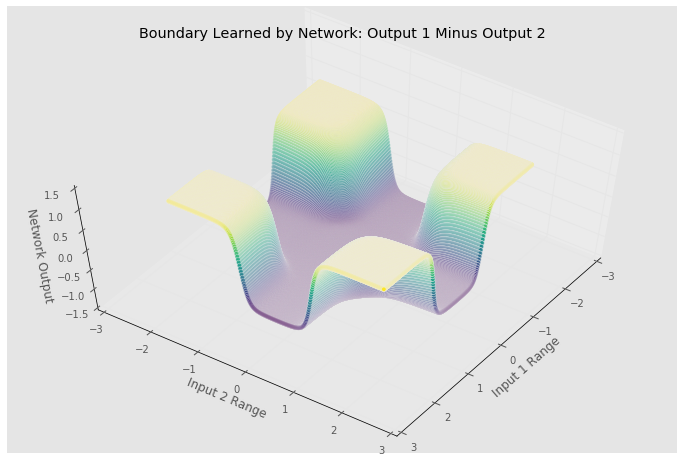

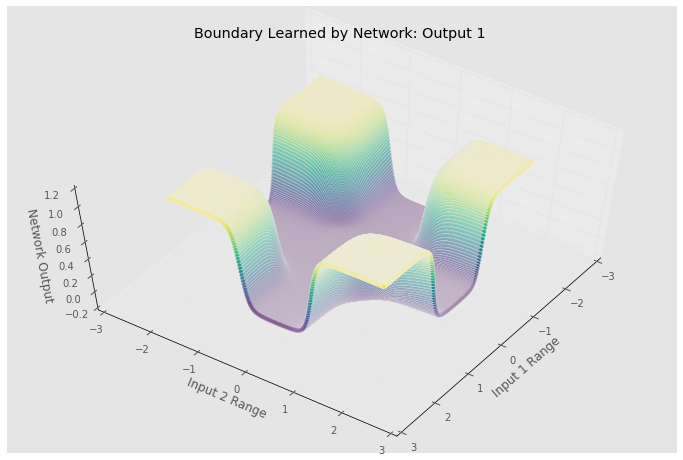

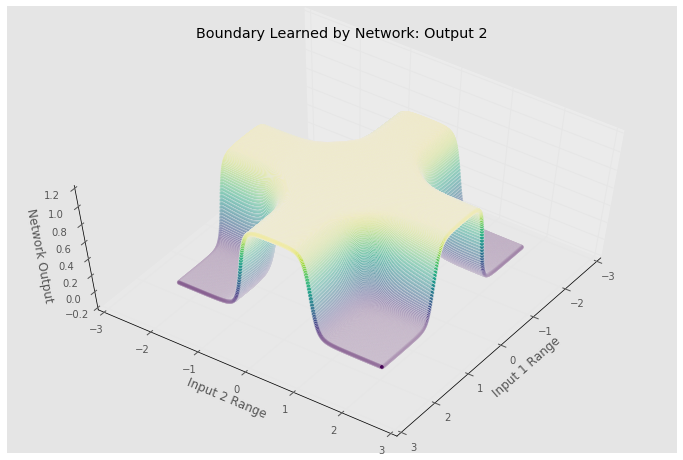

In [73]:
# Plot predictions to see the decision boundary
preds_sub = (predictions[:,0].T - predictions[:,1].T)
preds_1 = predictions[:,0].T
preds_2 = predictions[:,1].T

#Plot output 1 minus output 2
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.set_ylabel('Input 2 Range')
ax.set_xlabel('Input 1 Range')
ax.set_zlabel('Network Output')
ax.set_title("Boundary Learned by Network: Output 1 Minus Output 2")
ax.scatter(features[:,0], features[:,1], preds_sub, c=preds_sub, cmap='viridis', linewidth=0.5);

#Plot output 1
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.set_ylabel('Input 2 Range')
ax.set_xlabel('Input 1 Range')
ax.set_zlabel('Network Output')
ax.set_title("Boundary Learned by Network: Output 1 ")
ax.scatter(features[:,0], features[:,1], preds_1, c=preds_1, cmap='viridis', linewidth=0.5);

#Plot output 2
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.set_ylabel('Input 2 Range')
ax.set_xlabel('Input 1 Range')
ax.set_zlabel('Network Output')
ax.set_title("Boundary Learned by Network: Output 2")
ax.scatter(features[:,0], features[:,1], preds_2, c=preds_2, cmap='viridis', linewidth=0.5);


This gives a very vivid depiction of the boundary and how steeply it drops off between classes. 

### What if the we just use the two first two features? Do we get the same decision boundary? 
In order to test whether the third input helps our network, I created an identically structured network, except that only the first two inputs are used. The network is trained in the same fashion as above and the decision boundary is visualized. Since the decision boundary is the same after training on two features and three features, it is clear that the third feature isn't providing useful information while training the network. 

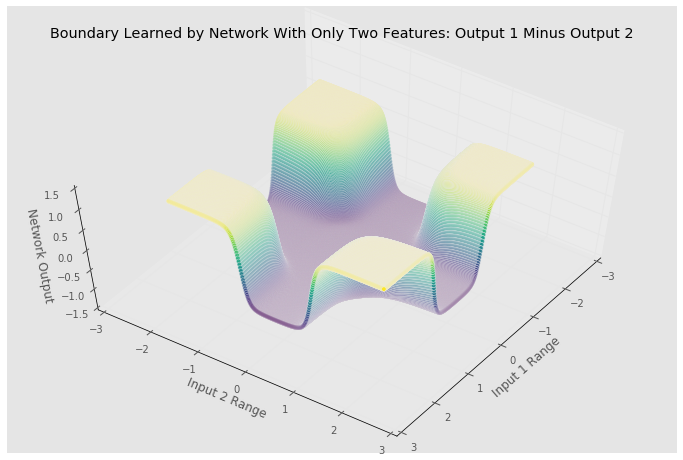

In [91]:
#Load the dataset        
dataset = genfromtxt('training_data.csv', delimiter=',')
features = dataset[:,0:2]
lables = dataset[:,3:5]

#Create a 2:11:2 network with alpha and bias    
network_2input = NeuralNetwork(2, 11, 2, .7, .3)
network_2input.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_2input.W1 = network_2input.W1[:,0:2]
network_2input.W1_prev_update = network_2input.W1[:,0:2]

features_grid_sub = decision_grid

#Train until the SSE delta is below threshold
network_2input.train(300, features, lables, .001)
predictions_sub = network_2input.evaluate(features_grid_sub)
preds_minus_sub = (predictions_sub[:,0].T - predictions_sub[:,1].T)

#Plot output 1 minus output 2
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.set_ylabel('Input 2 Range')
ax.set_xlabel('Input 1 Range')
ax.set_zlabel('Network Output')
ax.set_title("Boundary Learned by Network With Only Two Features: Output 1 Minus Output 2")
ax.scatter(features_grid_sub[:,0], features_grid_sub[:,1], preds_minus_sub, c=preds_minus_sub, cmap='viridis', linewidth=0.5);

### 2) The effect of learning rate

Here I varied the learning rate to see whether increasing/decreasing the value makes convergence faster. In each of these tests a network with the same architecture as above was trained on the cross dataset. The learning rates tested were:
- .7 
- .01
- .2
- .9

During these experiments beta was fixed at .3. 

I expected the learning rate to affect convergence, and this was the case. Alpha = .7 and Alpha = .9 performed the best, followed by a = .2 and finally a = .01. This shows that if the learning rate is too high or low, it can make convergence take much longer. This is especially the case with a very low learning rate. The effect of learning rate and momentum on convergence likely differ depending on the dataset. I also found it interesting that loss dropped rapidly the first few epochs, regardless of learning rate.

In [86]:
#Load the dataset        
dataset = genfromtxt('training_data.csv', delimiter=',')
training = dataset[:,0:3]
testing = dataset[:,3:5]

In [87]:
network_a = NeuralNetwork(3, 11, 2, .01, .3)
network_a.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_a.train(10000, training, testing, .001)

network_b = NeuralNetwork(3, 11, 2, .2, .3)
network_b.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_b.train(10000, training, testing, .001)

network_c = NeuralNetwork(3, 11, 2, .9, .3)
network_c.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_c.train(10000, training, testing, .001)

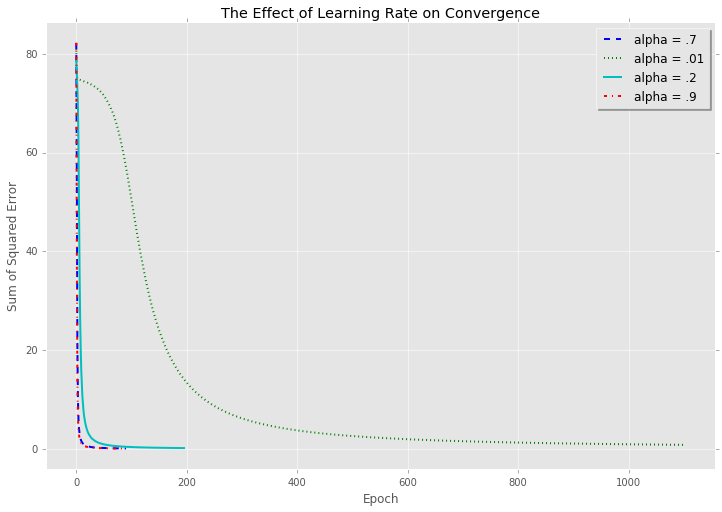

In [88]:
# Alpha comparison plot
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(len(np.array(network.SSE_epochs))), np.array(network.SSE_epochs), 'b--', label='alpha = .7', linewidth=2)
ax.plot(range(len(np.array(network_a.SSE_epochs))), np.array(network_a.SSE_epochs), 'g:', label='alpha = .01', linewidth=2)
ax.plot(range(len(np.array(network_b.SSE_epochs))), np.array(network_b.SSE_epochs), 'c-', label='alpha = .2', linewidth=2)
ax.plot(range(len(np.array(network_c.SSE_epochs))), np.array(network_c.SSE_epochs), 'r-.', label='alpha = .9', linewidth=2)
ax.set_ylabel('Sum of Squared Error')
ax.set_xlabel('Epoch')
ax.set_title("The Effect of Learning Rate on Convergence")
legend = ax.legend(loc='upper right', shadow=True)
ax.margins(0.05) # 5% padding in all directions

### 3) The effect of momentum

To explore how momentum helps with convergence, I fix the alpha at .01 and train a network of the same architecture with either no momentum or a momentum of .6. If momentum does help with convergence, it should converge faster with a momentum of .6 compared with no momentum. 

I expected that not having momentum would increase the time it takes the algorithm to converge, and that more momentum would be helpful to an extent. My intuition is that too much momentum could be bad in some situations, but would help with saddle points in loss functions. 

The experiment shows that a momentum of .6 causes quicker convergence then no momentum. What I find interesting is the quick initial drop in error from both functions in the first few epochs. Then, the momentum becomes more and more useful over time as it begins to build.


In [76]:
network_d = NeuralNetwork(3, 11, 2, 0.01, 0)
network_d.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_d.train(10000, training, testing, .001)

network_e = NeuralNetwork(3, 11, 2, 0.01, 0.6)
network_e.init_weights('w1.csv', 'w2.csv', 'b1.csv', 'b2.csv')
network_e.train(10000, training, testing, .001)

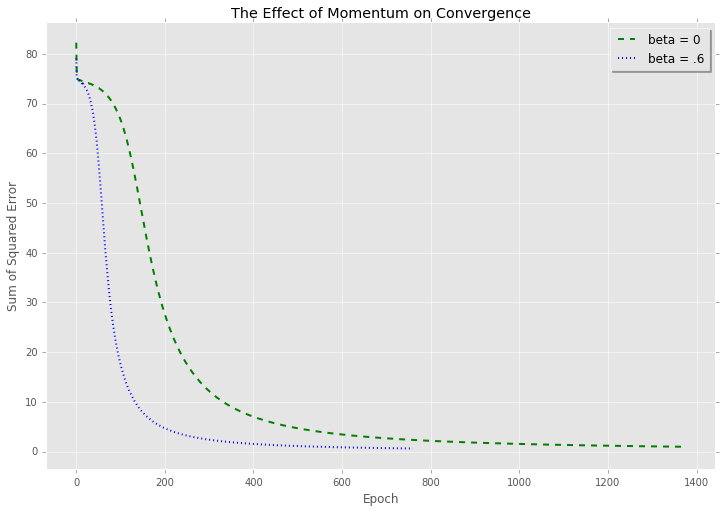

In [77]:
# Beta comparison plot
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(len(network_d.SSE_epochs)), np.array(network_d.SSE_epochs), 'g--', label='beta = 0', linewidth=2)
ax.plot(range(len(network_e.SSE_epochs)), np.array(network_e.SSE_epochs), 'b:', label='beta = .6', linewidth=2)

ax.set_ylabel('Sum of Squared Error')
ax.set_xlabel('Epoch')
ax.set_title("The Effect of Momentum on Convergence")
legend = ax.legend(loc='upper right', shadow=True)
ax.margins(0.05) # 5% padding in all directions


# Part 2: Cross Validation Experiment


First I reorganize the overall dataset such that the classes are every other row. 1,0,1,0,etc. This guarantees that when folds are selected for validation there will be an equal number of samples in each class. 

Next the data was split into 5 folds of 200 samples each. For each fold the subset of training data was shuffled and used to train each network configuration. In all experiments a learning rate of .7 and momentum of .3 was used since these parameters performed well on previous experiments. 

I decided to test network sizes in N incremented by powers of 2: 8, 16, and 32. I did this in order to get an idea of how the network will function as the hidden layer size increases. My intuition told me that 32 would not perform the best since it would possibly overfit the data, while 8 hidden units may not be enough to find a good boundary. 

Interestingly, the different numbers of hidden units did little to change the overall accuracy of the network. There is some variation, especially between type 1 and 2 error, but it does not appear to be very large.

In [85]:
#Load the dataset
dataset = genfromtxt('4Dgaussian.csv', delimiter=',')

class1 = dataset[0:500,:]
class2 = dataset[500:1000,:]

c = np.empty((1000,6), dtype=class1.dtype)
c[0::2] = class1
c[1::2] = class2

dataset = np.reshape(c, [1000,6]) 
training = dataset[:,0:4]
lables = dataset[:,4:]

X_train_folds = np.array_split(training, 5)
Y_train_folds = np.array_split(lables, 5)

y_true_all = np.array_split(np.zeros([1,1000]), 5)
y_pred_all = np.array_split(np.zeros([1,1000]),5)

### 8 hidden units and report all confusion matricies
Below, each confusion matrix displays accuracy across folds. Rows display true class labels (adds to 100 for each class within folds because an equal number of class labels are used), and columns show the output predicted by the network. The final output displays the aggregated confusion matrix.

In [82]:
#Split data into folds and train model
#Create a 4:8:2 network with alpha and bias    

networkcv = NeuralNetwork(4, 8, 2, .7, .3)
networkcv.init_weights_rand()

y_true_all = np.array_split(np.zeros([1,1000]), 5)
y_pred_all = np.array_split(np.zeros([1,1000]),5)

for i in range(5):

    #Feed in all other folds for training except test fold
    fold_X_train = np.concatenate(X_train_folds[:i] +  X_train_folds[i+1:])
    fold_Y_train = np.concatenate(Y_train_folds[:i] +  Y_train_folds[i+1:])
    
    #Shuffle data for first epoch and train
    p = np.random.permutation(len(fold_X_train))
    fold_X_train, fold_Y_train = fold_X_train[p], fold_Y_train[p]
    networkcv.train(10000, fold_X_train, fold_Y_train, .001)
    
    #Feed in test fold for evaluation
    predictions = networkcv.evaluate(X_train_folds[i])
    y_true = pd.Series(np.argmax(Y_train_folds[i], axis=1) + 1, name='Predicted') #Swap series names so it displays clearly
    y_pred = pd.Series(np.argmax(predictions, axis=1) + 1, name='True')
    
    y_true_all[i] = np.argmax(Y_train_folds[i], axis=1) + 1
    y_pred_all[i] = np.argmax(predictions, axis=1) + 1

    df_confusion = pd.crosstab(y_pred, y_true)
    print df_confusion
    print "\n\n"

    networkcv.init_weights_rand() #Reset network

y_true_all = pd.Series(np.concatenate(y_true_all[:]), name='Predicted')
y_pred_all = pd.Series(np.concatenate(y_pred_all[:]), name='True')
df_confusion_all = pd.crosstab(y_pred_all, y_true_all)
df_confusion_all

Predicted   1   2
True             
1          95   9
2           5  91



Predicted   1   2
True             
1          97   8
2           3  92



Predicted   1   2
True             
1          90   2
2          10  98



Predicted   1   2
True             
1          95   6
2           5  94



Predicted   1   2
True             
1          94   2
2           6  98





Predicted,1,2
True,,
1,471,27
2,29,473


### 16 Units

In [83]:
#Split data into folds and train model
#Create a 4:16:2 network with alpha and bias    

networkcv = NeuralNetwork(4, 16, 2, .7, .3)
networkcv.init_weights_rand()

y_true_all = np.array_split(np.zeros([1,1000]), 5)
y_pred_all = np.array_split(np.zeros([1,1000]),5)

for i in range(5):

    #Feed in all other folds for training except test fold
    fold_X_train = np.concatenate(X_train_folds[:i] +  X_train_folds[i+1:])
    fold_Y_train = np.concatenate(Y_train_folds[:i] +  Y_train_folds[i+1:])
    
    #Shuffle data for first epoch and train
    p = np.random.permutation(len(fold_X_train))
    fold_X_train, fold_Y_train = fold_X_train[p], fold_Y_train[p]
    networkcv.train(10000, fold_X_train, fold_Y_train, .001)
    
    #Feed in test fold for evaluation
    predictions = networkcv.evaluate(X_train_folds[i])
    y_true = pd.Series(np.argmax(Y_train_folds[i], axis=1) + 1, name='Predicted') #Swap series names so it displays clearly
    y_pred = pd.Series(np.argmax(predictions, axis=1) + 1, name='True')
    
    y_true_all[i] = np.argmax(Y_train_folds[i], axis=1) + 1
    y_pred_all[i] = np.argmax(predictions, axis=1) + 1


    networkcv.init_weights_rand() #Reset network

y_true_all = pd.Series(np.concatenate(y_true_all[:]), name='Predicted')
y_pred_all = pd.Series(np.concatenate(y_pred_all[:]), name='True')
df_confusion_all = pd.crosstab(y_pred_all, y_true_all)
df_confusion_all

Predicted,1,2
True,,
1,464,19
2,36,481


### 32 Units

In [84]:
#Create a 4:32:2 network with alpha and bias    

networkcv = NeuralNetwork(4, 32, 2, .7, .3)
networkcv.init_weights_rand()

y_true_all = np.array_split(np.zeros([1,1000]), 5)
y_pred_all = np.array_split(np.zeros([1,1000]),5)

for i in range(5):

    #Feed in all other folds for training except test fold
    fold_X_train = np.concatenate(X_train_folds[:i] +  X_train_folds[i+1:])
    fold_Y_train = np.concatenate(Y_train_folds[:i] +  Y_train_folds[i+1:])
    
    #Shuffle data for first epoch and train
    p = np.random.permutation(len(fold_X_train))
    fold_X_train, fold_Y_train = fold_X_train[p], fold_Y_train[p]
    networkcv.train(10000, fold_X_train, fold_Y_train, .001)
    
    #Feed in test fold for evaluation
    predictions = networkcv.evaluate(X_train_folds[i])
    y_true = pd.Series(np.argmax(Y_train_folds[i], axis=1) + 1, name='Predicted') #Swap series names so it displays clearly
    y_pred = pd.Series(np.argmax(predictions, axis=1) + 1, name='True')
    
    y_true_all[i] = np.argmax(Y_train_folds[i], axis=1) + 1
    y_pred_all[i] = np.argmax(predictions, axis=1) + 1


    networkcv.init_weights_rand() #Reset network

y_true_all = pd.Series(np.concatenate(y_true_all[:]), name='Predicted')
y_pred_all = pd.Series(np.concatenate(y_pred_all[:]), name='True')
df_confusion_all = pd.crosstab(y_pred_all, y_true_all)
df_confusion_all

Predicted,1,2
True,,
1,474,28
2,26,472
